입력 문자열과 출력 문자열이 매 문장마다 다르다는 문제점이 있었고, 
이를 해결하기 위해 Encoder-decoder가 도입되었다.

이를 구현하기 위해 두개의 RNN을 사용할 것.
이는 RNN이 우선 variable-length의 문자열을 입력으로 받아서, 고정된 모양의 hidden-state로 계산한다. 그 다음 decoder로 들어가 새로운 문자열을 출력해 내는 것이다

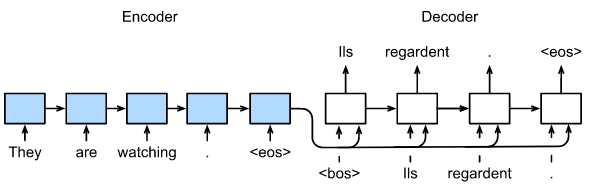


"eos"는 문장의 끝을 의미한다고 했는데, 해당 토큰이 생성되면, 모델은 prediction을 멈추게 된다.
    
“bos”, “Ils”, “regardent”, “.”  “Ils”, “regardent”, “.”, “eos”.



In [1]:
import collections
import math
import torch
from torch import nn
from d2l import torch as d2l

# 9.7.1. Encoder

- unidirectional RNN에 대한 수식

\begin{split}\begin{aligned}
\mathbf{h}_t = f(\mathbf{x}_t, \mathbf{h}_{t-1}).
\end{aligned}\end{split}

- bidirectional RNN에 대한 설명

bidirectional RNN의 경우에는 hidden state가 이전과 이후 time step의 결과에 영향을 받는다. 

In [2]:
class Seq2seqEncoder(d2l.Encoder):
    """
    RNN encoder
    """
    def __init__(self, vocab_size, emb_size, num_hiddens, num_layers, dropout=0, **kwargs):
        super(Seq2seqEncoder, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.rnn = nn.GRU(emb_size, num_hiddens, num_layers, dropout=dropout)
    def forward(self, X, *args):
        X = self.embedding(X)
        # RNN에 입력으로 들어가려면, 첫번째 축이 time step이어야 한다.
        X = X.permute(1,0,2)
        output, state = self.rnn(X)
        
        # output shape: (num_steps, batch_size, num_hiddens)
        # state shape: (num_steps, batch_size, num_hiddens)
        return output, state
        
        

In [4]:
encoder = Seq2seqEncoder(vocab_size=10, emb_size=8, num_hiddens=16, num_layers=2)
encoder.eval()

# batch size: 4, num_of_timesteps: 7
X = torch.zeros((4,7), dtype=torch.long)
output, state = encoder(X)
output.shape

torch.Size([7, 4, 16])

In [5]:
# num layer, batch size, num hiddens
state.shape

torch.Size([2, 4, 16])

# 9.7.2. Decoder
